In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
from contractions import contractions_dict
def expand_contractions(text, contraction_map=None):
    if contraction_map is None:
        contraction_map = contractions_dict

    # Using regex for getting all contracted words
    contractions_keys = '|'.join(re.escape(key) for key in contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    expanded_text = contractions_pattern.sub(lambda match: contraction_map.get(match.group(0), match.group(0)), text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [3]:
entertainment = pd.read_csv('data/BBCNewsSummaryCSV/entertainment_data.csv') 
sport = pd.read_csv('data/BBCNewsSummaryCSV/sport_data.csv')
tech = pd.read_csv('data/BBCNewsSummaryCSV/tech_data.csv')
business = pd.read_csv('data/BBCNewsSummaryCSV/business_data.csv')
politics = pd.read_csv('data/BBCNewsSummaryCSV/politics_data.csv')

In [4]:
training_dataset = pd.concat([entertainment,sport,tech], ignore_index=True)
testing_dataset = pd.concat([business,politics], ignore_index=True)

In [5]:
print("Training size:",training_dataset.size)
print("Testing size:",testing_dataset.size)

Training size: 3894
Testing size: 2781


In [6]:
training_dataset = training_dataset.sample(frac=1).reset_index(drop=True)
testing_dataset = testing_dataset.sample(frac=1).reset_index(drop=True)

In [7]:
training_dataset['newsarticle'] = training_dataset['newsarticle'].apply(expand_contractions)
testing_dataset['newsarticle'] = testing_dataset['newsarticle'].apply(expand_contractions)

In [8]:
def getSenLen(sentence):
    return len(sentence.split())

In [9]:
training_dataset['article_length'] = training_dataset['newsarticle'].apply(getSenLen)
training_dataset['summary_length'] = training_dataset['summary'].apply(getSenLen)
testing_dataset['article_length'] = testing_dataset['newsarticle'].apply(getSenLen)
testing_dataset['summary_length'] = testing_dataset['summary'].apply(getSenLen)


In [10]:
training_dataset.head()

,filename,newsarticle,summary,article_length,summary_length
0,sport_353,Scots suffer another injury blow\n\nScotlands ...,"Another potential option, Glasgow flanker Andr...",258,108
1,sport_364,A year to remember for Irish\n\nThere used to ...,While Ulster finished runners-up in their very...,778,343
2,entertainment_295,Dame Julie pops in to see Poppins\n\nMary Popp...,"But Kelly said she was ""very nervous"" about me...",224,92
3,entertainment_069,Foxx and Swank take actors awards\n\nJamie Fox...,Jamie Foxx and Hilary Swank have won the Scree...,338,137
4,sport_359,Ruddock backs Yapps credentials\n\nWales coach...,Wales coach Mike Ruddock says John Yapp has wh...,375,156


In [11]:
training_dataset.describe()

,article_length,summary_length
count,1298.000000,1298.000000
mean,385.013097,165.270416
std,243.616315,109.734916
min,115.000000,42.000000
25%,235.000000,99.250000
50%,323.000000,137.000000
75%,465.750000,202.750000
max,3540.000000,1706.000000


Text(0.5, 1.0, 'Boxplot of Summary Lengths')

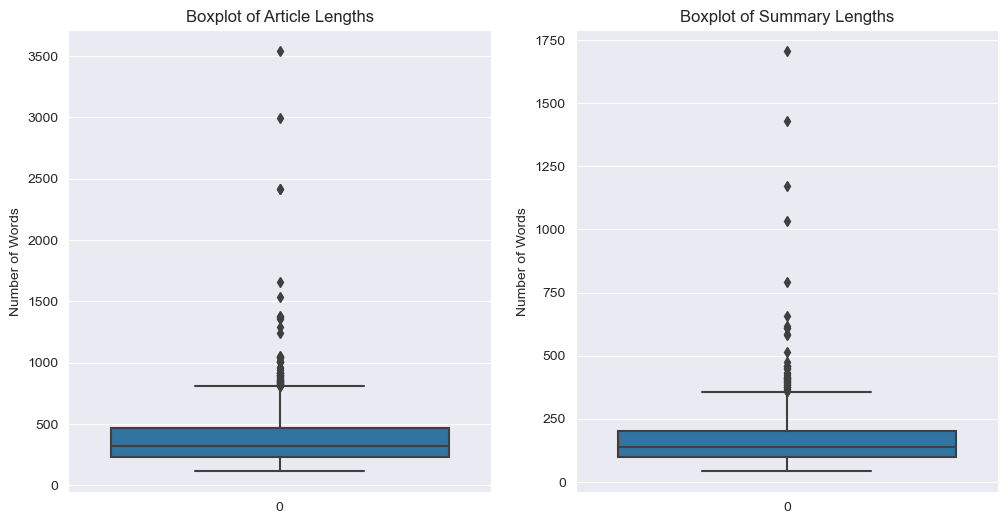

In [12]:
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for the articles' number of words
sns.boxplot(training_dataset["article_length"], ax=axes[0])
axes[0].set_ylabel("Number of Words")
axes[0].set_title("Boxplot of Article Lengths")

# Plot for the summaries' number of words
sns.boxplot(training_dataset["summary_length"], ax=axes[1])
axes[1].set_ylabel("Number of Words")
axes[1].set_title("Boxplot of Summary Lengths")


In [13]:
# Get statistics for the articles boxplot
lines_articles = axes[0].lines[:6]
articles_stats = [line.get_ydata()[0] for line in lines_articles]
Q1_articles, Q3_articles, lower_whisker_articles, upper_whisker_articles, median_articles = articles_stats[:5]

# Get statistics for the summaries boxplot
lines_summaries = axes[1].lines[:6]
summaries_stats = [line.get_ydata()[0] for line in lines_summaries]
Q1_summaries, Q3_summaries, lower_whisker_summaries, upper_whisker_summaries, median_summaries = summaries_stats[:5]

In [14]:
print(upper_whisker_articles)
print(upper_whisker_summaries)

810.0
355.0


In [15]:
training_dataset = training_dataset[(training_dataset['summary_length'] <= upper_whisker_summaries) & (training_dataset['article_length'] <= upper_whisker_articles)]
testing_dataset = testing_dataset[(testing_dataset['summary_length'] <= upper_whisker_summaries) & (testing_dataset['article_length'] <= upper_whisker_articles)]

In [16]:
training_dataset.head()

,filename,newsarticle,summary,article_length,summary_length
0,sport_353,Scots suffer another injury blow\n\nScotlands ...,"Another potential option, Glasgow flanker Andr...",258,108
1,sport_364,A year to remember for Irish\n\nThere used to ...,While Ulster finished runners-up in their very...,778,343
2,entertainment_295,Dame Julie pops in to see Poppins\n\nMary Popp...,"But Kelly said she was ""very nervous"" about me...",224,92
3,entertainment_069,Foxx and Swank take actors awards\n\nJamie Fox...,Jamie Foxx and Hilary Swank have won the Scree...,338,137
4,sport_359,Ruddock backs Yapps credentials\n\nWales coach...,Wales coach Mike Ruddock says John Yapp has wh...,375,156


In [17]:
training_dataset.describe()

,article_length,summary_length
count,1240.000000,1240.000000
mean,351.926613,150.501613
std,156.300192,67.456332
min,115.000000,42.000000
25%,233.000000,97.000000
50%,315.000000,133.500000
75%,441.000000,190.000000
max,810.000000,354.000000


In [18]:
df = training_dataset[1:30]

In [19]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from rouge_score import rouge_scorer
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_

In [20]:
# Define the device for GPU usage (if available)
if torch.backends.mps.is_available():
    arch = "mps"
elif torch.cuda.is_available():
    arch = "cuda"
else:
    arch = "cpu"

device = torch.device(arch)

In [21]:
# Tokenize and preprocess the text data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
max_length = 512  # Maximum sequence length

def tokenize_text(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized inputs to the GPU

def tokenize_summary(text):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=280, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized summaries to the GPU

def tokenize_and_stack(df, text_column, summary_column):
    df['TokenizedText'] = df[text_column].apply(tokenize_text)
    df['TokenizedSummary'] = df[summary_column].apply(tokenize_summary)
    
    # Convert tokenized data to PyTorch tensors
    X = torch.stack([seq.squeeze() for seq in df['TokenizedText']])
    Y = torch.stack([seq.squeeze() for seq in df['TokenizedSummary']])
    
    # Define a DataLoader for batching data
    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    return X, Y, dataloader

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize and stack for training set
X_train, Y_train, train_dataloader = tokenize_and_stack(train_df, 'newsarticle', 'summary')

# Tokenize and stack for validation set
X_val, Y_val, val_dataloader = tokenize_and_stack(val_df, 'newsarticle', 'summary')

# Tokenize and stack for validation set
X_test, Y_test, test_dataloader = tokenize_and_stack(testing_dataset, 'newsarticle', 'summary')


In [22]:
# Define the BART model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Create a GradScaler for mixed-precision training
scaler = GradScaler()

# Define hyperparameters
model.to(device)  # Move the model to the GPU
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=len(train_dataloader) * 10)  # Add learning rate scheduler
early_stopping_rounds = 2
best_rouge_score = -1
current_round = 0

# Define gradient accumulation steps
accumulation_steps = 20  # You can adjust this number


/Users/kysgattu/anaconda3/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:124: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [23]:
def train(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(dataloader, desc="Training")):
        inputs = batch[0].to(device)  # Move the input batch to the GPU
        attention_mask = (inputs != 0).float().to(device)  # Create attention mask
        targets = batch[1].to(device)  # Move the target batch to the GPU

        with autocast():
            outputs = model(input_ids=inputs, attention_mask=attention_mask, decoder_input_ids=targets, labels=targets)
            loss = outputs.loss

        # Perform gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:
            # Update gradients and optimizer once every accumulation_steps
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Optional gradient clipping
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [24]:
# Training loop
for epoch in range(2):  # Change the number of epochs as needed
    train_loss = train(model, train_dataloader, optimizer, scheduler)
    print(f"Epoch {epoch+1}/{2}, Train Loss: {train_loss:.4f}")

model.save_pretrained("saved_model")

Training:   0%|          | 0/6 [00:00<?, ?it/s]/Users/kysgattu/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Epoch 1/2, Train Loss: 0.6608


Training: 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]


Epoch 2/2, Train Loss: 0.6416


In [26]:
def evaluate(model, dataloader):
    model.eval()
    
    test_articles = []
    actual_summaries = []
    predicted_summaries = []
    rouge1_precision_scores = []

    scorer = rouge_scorer.RougeScorer(['rouge1'])

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Test"):
            inputs = batch[0].to(device)
            attention_mask = (inputs != 0).float().to(device)
            targets = batch[1].to(device)
            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=150, num_beams=17, length_penalty=2.0, early_stopping=False)
            
            for output, target, input_text in zip(outputs, targets, inputs):
                # Calculate ROUGE-1 precision for each sample
                output_text = tokenizer.decode(output, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)
                rouge_scores = scorer.score(output_text, target_text)
                rouge1_precision_scores.append(rouge_scores['rouge1'].fmeasure)
                
                # Append tokenized text, actual summaries, and predicted summaries
                test_articles.append(tokenizer.decode(input_text, skip_special_tokens=True))
                actual_summaries.append(target_text)
                predicted_summaries.append(output_text)

    return test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores

# Evaluate the model
test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores = evaluate(model, val_dataloader)

# Create a dictionary with the extracted data
data = {
    'Article': test_articles,
    'Actual Summary': actual_summaries,
    'Predicted Summary': predicted_summaries,
    'ROUGE-1 Precision': rouge1_precision_scores,
}

# Create a Pandas DataFrame from the dictionary
results_df = pd.DataFrame(data)

# Display the DataFrame
pd.set_option('display.max_colwidth', None)
results_df.head(5)

Evaluating Test:  50%|█████     | 1/2 [01:26<01:26, 86.09s/it]

{'rouge1': Score(precision=0.5272727272727272, recall=0.48739495798319327, fmeasure=0.5065502183406113)}
{'rouge1': Score(precision=0.60625, recall=0.8220338983050848, fmeasure=0.697841726618705)}
{'rouge1': Score(precision=0.5754716981132075, recall=0.5398230088495575, fmeasure=0.5570776255707762)}
{'rouge1': Score(precision=0.3836477987421384, recall=0.5350877192982456, fmeasure=0.4468864468864469)}


Evaluating Test: 100%|██████████| 2/2 [01:47<00:00, 53.72s/it]

{'rouge1': Score(precision=0.4457831325301205, recall=0.5967741935483871, fmeasure=0.5103448275862069)}
{'rouge1': Score(precision=0.5942857142857143, recall=0.8253968253968254, fmeasure=0.6910299003322259)}


,Article,Actual Summary,Predicted Summary,ROUGE-1 Precision
0,"summarize: Holmes secures comeback victory\n\nBritains Kelly Holmes marked her first appearance on home soil since winning double Olympic gold with 1500m victory at the Norwich Union International.\n\nHolmes hit the front just before the bell in front of a sell-out crowd in Glasgow and cruised to victory in a time of four minutes 14.74 seconds. ""It was nice to get that out of the way. I was nervous about whether I would actually be able to get round. ""I felt good. I just had to relax and use my racing knowledge,"" said Holmes. ""It was all about winning in front of my home crowd. The time is irrelevant. ""I got round in one piece and did not disgrace myself. Now it is about going forward. ""The reception I have had since the Olympics has been amazing and that is why I wanted to keep running this year, because I get a buzz from the crowd."" Holmes ran a tactically perfect race to finish clear of Frances Hind Dehiba and Russias Svetlana Cherkasova. The Olympic 800m and 1500m champions time was inside the qualifying mark for the European Indoor Championships in Madrid in March. But the 34-year-old would not reveal whether she intended to run or not, having previously indicated she would leave a decision until after the Birmingham Grand Prix on 18 February.\n","I was nervous about whether I would actually be able to get round.""It was all about winning in front of my home crowd.Holmes hit the front just before the bell in front of a sell-out crowd in Glasgow and cruised to victory in a time of four minutes 14.74 seconds.""It was nice to get that out of the way.The Olympic 800m and 1500m champion's time was inside the qualifying mark for the European Indoor Championships in Madrid in March.Britain's Kelly Holmes marked her first appearance on home soil since winning double Olympic gold with 1500m victory at the Norwich Union International.","summarize: Holmes secures comeback victory in a time of 4 minutes 14.74 seconds. ""I felt good. I just had to relax and use my racing knowledge,"" said Holmes. ""It was all about winning in front of my first appearance on home soil since winning double Olympic gold with 1500m victory at the Norwich Union International. Now it is about going forward. ""The reception I have had since the Olympics has been amazing and that is why I wanted to keep running this year, because I get a buzz from the crowd."" Holmes ran a tactically perfect race to finish clear of Frances Hind Dehiba and Russias Svetlana Cherkasova. “I got round in one piece and did not disgrace",0.527273
1,"summarize: Parmar ruled out of Davis Cup tie\n\nA knee injury has forced Arvind Parmar out of Great Britains Davis Cup tie in Israel and left Alex Bogdanovic in line to take the second singles place.\n\nParmar picked up the injury last week and has failed to recover in time for the Europe/Africa Zone I tie, which begins in Tel Aviv on Friday. Bogdanovic looks set to take the second singles place alongside Greg Rusedski. GB captain Jeremy Bates could use 17-year-old Andrew Murray and David Sherwood in the doubles rubber. Bogdanovic and Murray both pulled out of tournaments last week through injury but are expected to be fit. Jamie Delgado and Lee Childs have been called into the squad in Tel Aviv as designated hitters for team practice but Bates has no plans to call either of them into his squad at present.\n\nThe unheralded Sherwood was the surprise inclusion when the squad was announced last week, and Bates said: ""David has earned his place in this squad on the merit of his form and results over the last 12 months."" The 6ft 4in Sherwood is ranked 264th in the world and the LTA have high hopes for him after Futures tournament wins in Wrexham and Edinburgh.\n\nThe Sheffield-born right-hander, aged 24, also reached another final in Plaisir, France, a week after making the semi-final in Mulhouse. Bates is glad to have Rusedski available after Tim Henmans retirement from